In [1]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [3]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [4]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


In [5]:
node_subjects.to_frame()

,subject
31336,Neural_Networks
1061127,Rule_Learning
1106406,Reinforcement_Learning
13195,Reinforcement_Learning
37879,Probabilistic_Methods
...,...
1128975,Genetic_Algorithms
1128977,Genetic_Algorithms
1128978,Genetic_Algorithms
117328,Case_Based


In [6]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [7]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Probabilistic_Methods,22
Genetic_Algorithms,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


In [8]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [9]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [10]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [11]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [12]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<tf.Tensor 'gather_indices/Identity:0' shape=(1, None, 16) dtype=float32>

In [13]:

predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)



In [14]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [15]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [17]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 0s - loss: 1.9398 - acc: 0.1857 - val_loss: 1.9056 - val_acc: 0.3760
Epoch 2/200
1/1 - 0s - loss: 1.8952 - acc: 0.3857 - val_loss: 1.8495 - val_acc: 0.3540
Epoch 3/200
1/1 - 0s - loss: 1.8209 - acc: 0.3786 - val_loss: 1.7753 - val_acc: 0.3400
Epoch 4/200
1/1 - 0s - loss: 1.7270 - acc: 0.3714 - val_loss: 1.6953 - val_acc: 0.3360
Epoch 5/200
1/1 - 0s - loss: 1.6211 - acc: 0.3571 - val_loss: 1.6254 - val_acc: 0.3260
Epoch 6/200
1/1 - 0s - loss: 1.5308 - acc: 0.3214 - val_loss: 1.5676 - val_acc: 0.3280
Epoch 7/200
1/1 - 0s - loss: 1.4390 - acc: 0.3571 - val_loss: 1.5084 - val_acc: 0.3420
Epoch 8/200
1/1 - 0s - loss: 1.3310 - acc: 0.3857 - val_loss: 1.4366 - val_acc: 0.3900
Epoch 9/200
1/1 - 0s - loss: 1.2412 - acc: 0.4714 - val_loss: 1.3521 - val_acc: 0.4700
Epoch 10/200
1/1 - 0s - loss: 1.1497 - acc: 0.5929 - val_loss: 1.2680 - val_acc: 0.5480
Epoch 11/200
1/1 - 0s - loss: 1.0480 - acc: 0.6571 - val_loss: 1.1937 - val_acc: 0.6460
Epoch 12/200
1/1 - 0s - loss: 0.9216 - ac

Epoch 95/200
1/1 - 0s - loss: 0.0743 - acc: 0.9786 - val_loss: 1.0777 - val_acc: 0.7920
Epoch 96/200
1/1 - 0s - loss: 0.0352 - acc: 0.9786 - val_loss: 1.0696 - val_acc: 0.7920
Epoch 97/200
1/1 - 0s - loss: 0.0151 - acc: 1.0000 - val_loss: 1.0646 - val_acc: 0.7940
Epoch 98/200
1/1 - 0s - loss: 0.0288 - acc: 0.9929 - val_loss: 1.0608 - val_acc: 0.7940
Epoch 99/200
1/1 - 0s - loss: 0.0245 - acc: 0.9857 - val_loss: 1.0590 - val_acc: 0.7980
Epoch 100/200
1/1 - 0s - loss: 0.0162 - acc: 0.9929 - val_loss: 1.0610 - val_acc: 0.8000
Epoch 101/200
1/1 - 0s - loss: 0.0427 - acc: 0.9857 - val_loss: 1.0718 - val_acc: 0.7980
Epoch 102/200
1/1 - 0s - loss: 0.0396 - acc: 0.9929 - val_loss: 1.0865 - val_acc: 0.7960
Epoch 103/200
1/1 - 0s - loss: 0.0095 - acc: 1.0000 - val_loss: 1.1016 - val_acc: 0.7940
Epoch 104/200
1/1 - 0s - loss: 0.0321 - acc: 0.9857 - val_loss: 1.1192 - val_acc: 0.7900
Epoch 105/200
1/1 - 0s - loss: 0.0266 - acc: 0.9857 - val_loss: 1.1328 - val_acc: 0.7860
Epoch 106/200
1/1 - 0s - l

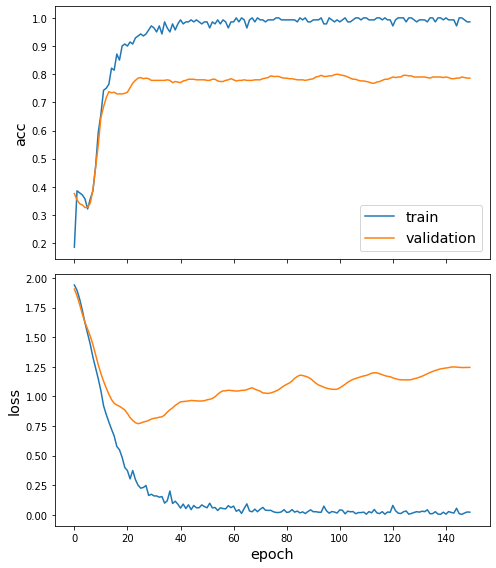

In [18]:
sg.utils.plot_history(history)

In [19]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [20]:

test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))



1/1 [==============================] - 0s 0s/step - loss: 1.0597 - acc: 0.7979

Test Set Metrics:
	loss: 1.0597
	acc: 0.7979


In [21]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [22]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory
